In [ ]:
# Download data
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'andrewmvd/medical-mnist'
!unzip -q medical-mnist.zip -d data
!rm medical-mnist.zip

Saving kaggle.json to kaggle.json
 99% 84.0M/84.8M [00:03<00:00, 18.4MB/s]
100% 84.8M/84.8M [00:03<00:00, 24.2MB/s]


In [ ]:
# Installations
!pip install pytorch-lightning
!pip install wandb
# !pip install torchvision

In [ ]:
# Imports
import os
from torchvision.datasets import ImageFolder
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from pytorch_lightning.core.lightning import LightningModule

In [ ]:
# Data preparation

class MedicalDataMNIST(pl.LightningDataModule):
    def __init__(self, num_workers=1):
      super().__init__()
      self.num_workers = num_workers
      self.labels_map = {0 : "AbdomenCT",
                         1 : "BreastMRI",
                         2 : "CXR",
                         3 : "ChestCT",
                         4 : "Hand",
                         5 : "HeadCT"}
      self.train_transform = transforms.Compose([transforms.ColorJitter(hue=.20, saturation=.20),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomVerticalFlip(),
                                                 transforms.RandomRotation(10),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                      std=[0.229, 0.224, 0.225])])
      
      self.val_test_transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])])
      

    def prepare_data(self):
      pass
      # called only on 1 GPU
      # ONLY DOWNLOAD!!!
      
    def setup(self, stage=None):

      self.dataset = ImageFolder("./data/")
      train_size = int(0.7 * len(self.dataset)) # take 70% for training
      val_size = int(0.2 * len(self.dataset)) # take 20% for validation
      test_size = len(self.dataset) - (train_size + val_size) # take 10% for test
      
      self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(self.dataset, [train_size, val_size, test_size])

      self.train_set.dataset.transform = self.train_transform
      self.val_set.dataset.transform = self.val_test_transform
      self.test_set.dataset.transform = self.val_test_transform

    def train_dataloader(self):
      return DataLoader(self.train_set, batch_size=128, shuffle=True, num_workers=self.num_workers) # 128 batch_size is max

    def val_dataloader(self):
      return DataLoader(self.val_set, batch_size=128, num_workers=self.num_workers)

    def test_dataloader(self):
      print("TEST DATALOADER")
      return DataLoader(self.test_set, batch_size=128, num_workers=self.num_workers)

    def visualize_dataset(self):
      # Visualizes dataset
      figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, cols * rows + 1):
          sample_idx = torch.randint(len(self.train_set), size=(1,)).item()
          norm_img, label = self.train_set[sample_idx]
          mean = torch.tensor([0.485, 0.456, 0.406])
          std = torch.tensor([0.229, 0.224, 0.225])
          img = norm_img * std[:, None, None] + mean[:, None, None] 
          figure.add_subplot(rows, cols, i)
          plt.title(self.labels_map[label])
          plt.axis("off")
          plt.imshow(img.permute(1, 2, 0))
      plt.show()

    def visualize_dataloader(self):
      # Display image and label
      train_dataloader = self.train_dataloader()
      train_features, train_labels = next(iter(train_dataloader))
      print(f"Feature batch shape: {train_features.size()}")
      print(f"Labels batch shape: {train_labels.size()}")
      norm_img = train_features[0]
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      img = norm_img * std[:, None, None] + mean[:, None, None]
      label = train_labels[0]
      plt.imshow(img.permute(1, 2, 0))
      plt.show()
      print(f"Label: {self.labels_map[label.item()]}")

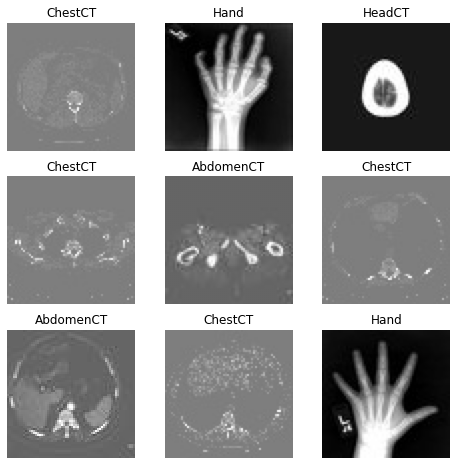

Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


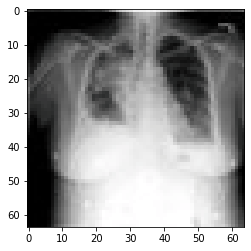

Label: CXR


In [ ]:
dm = MedicalDataMNIST()
dm.setup()
dm.visualize_dataset()
dm.visualize_dataloader()

In [ ]:
# Creating model
import torchmetrics

class MedicalMNIST(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.efficientnet_b7(pretrained=True)
        self.model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=False),
                                                    torch.nn.Linear(in_features=self.model.classifier[1].in_features, out_features=6))
        # num_ftrs = self.model.fc.in_features
        # self.model.fc = torch.nn.Linear(num_ftrs, 6)
        
        
    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = torch.nn.functional.cross_entropy(logits, y)

        self.log('train/loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        
        self.log('valid/loss', loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
# MAIN

# Import wandb
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='Medical MNIST', log_model='all')

# Number of cpus and gpus
NUM_DATALOADER_WORKERS = os.cpu_count()
print(f"Number of CPUS: {NUM_DATALOADER_WORKERS}")
NUM_GPUS = torch.cuda.device_count() if torch.cuda.is_available() else None
print(f"Number of GPUS: {NUM_GPUS}")

# Train
medical_mnist_data = MedicalDataMNIST(num_workers=NUM_DATALOADER_WORKERS)
model = MedicalMNIST()
trainer = Trainer(gpus=NUM_GPUS, max_epochs=4, logger = wandb_logger)

wandb_logger.watch(model)
trainer.fit(model, datamodule=medical_mnist_data)

Number of CPUS: 2
Number of GPUS: 1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 63.8 M
---------------------------------------
63.8 M    Trainable params
0         Non-trainable params
63.8 M    Total params
255.209   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]